# Deep ensemble for ENSO-forecasting

In this tutorial you learn how to use a neural network model called Deep Ensemble (DE) for the ENSO forecasting. This network architecture was initially developed [Lakshminarayanan et al. (2017)](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf). 

DEs are feed foreword neural networks that predict the mean and the standard deviation of a Gaussian. Hence, their predicion comes with an uncertainty estimation which is a valuable feature for ENSO-forecasting.

## Create a data pipe line

At first, we define a data pipeline. This is in general quite useful to keep your code clean and also to reuse the pipeline for later purpose.

The data pipeline generates returns:

1. The feature array

2. The label array

3. The time  array corresponding to the time of the label

NOTE (again): Lead time is defined as the time that passed between the last observed and the first date of the target season. Hence, negative appear, e.g. if you compare the DJF season with the target season JFM, you have a lead time of -2 month (Last observed date: Feburary 28/29, First date of the target season January 1).

In [7]:
from ninolearn.IO.read_processed import data_reader
from ninolearn.IO.read_raw import ZC_simple_read
import numpy as np
import pandas as pd

from ninolearn.learn.fit import n_decades, lead_times, decade_color, decade_name
from ninolearn.learn.evaluation import evaluation_correlation, evaluation_decadal_correlation, evaluation_seasonal_correlation, evaluation_decadal_correlation_ZC
from ninolearn.learn.fit import cross_hindcast_dem
from ninolearn.plot.evaluation import plot_seasonal_skill_ZC
import matplotlib.pyplot as plt
from ninolearn.learn.fit import cross_training
from ninolearn.learn.fit import cross_hindcast_dem
from ninolearn.learn.models import DEM

oneyear= pd.Timedelta(365, 'D')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys

train_version = 'de08nosc'
test_version = 'mu28v4'
name = 'dem' + '_'+ train_version  + '_' + test_version
# leadtime = 12

# t_start is defined using a funky timedelta because the starting date of the network analysis data is the last month
# of its start year which is 1951-12 therefore the time must start in 1952 with some months added for values lost in 
# interpolation. TODO: fix this by backwards interpolating the first values of the year and finding out what is happening 
# with the nms
train_times = np.unique(ZC_simple_read(train_version)['time'])
test_times = np.unique(ZC_simple_read(test_version)['time'])

train_t_start = train_times[0] + pd.Timedelta((2*365 + 90),'D')
train_t_end = train_times[-1] - pd.Timedelta(90,'D')

test_t_start = test_times[0] + pd.Timedelta((2*365 + 90),'D')
test_t_end = test_times[-1] - pd.Timedelta(90,'D')

print(f'tstart = {train_t_start} and tend = {train_t_end} (train)')
print(f'tstart = {test_t_start} and tend = {test_t_end} (test)')

t_start = train_t_start
t_end = train_t_end
times = train_times

if train_t_end < pd.Timestamp('1990-01-01') or test_t_end < pd.Timestamp('1990-01-01'):
    raise ValueError('one or both timeseries are too short!')
    

tstart = 1952-04-07 14:17:30 and tend = 1994-08-26 03:33:20 (train)
tstart = 1952-04-07 14:17:30 and tend = 1994-08-26 03:33:20 (test)


In [5]:
time = pd.Timestamp('1999-01-01')
print(time)

1999-01-01 00:00:00


In [6]:
from ninolearn.IO.read_raw import ZC_raw, ZC_h, ZC_oni
from ninolearn.preprocess.prepare import prep_nms
from ninolearn.plot.ZC_dem_plots import nms_plots
## read raw ZC data and save to 1x1 grid file in processeddir
## also makes field of h and sst
ZC_raw(train_version)

## calculates monthly averaged (?) fields of thermocline height within region 
## of interest. cacluate ONI in region of interest. calculate network metrics 
## from sst (Henk's suggestion) or thermocline height (like Paul)
ZC_h(train_version)
ZC_oni(train_version)

prep_nms(train_version, 0.99, t_start, t_end)

# make plots
# nms_plots(train_version)


using dimensions ('lat', 'lon') from data variable temperature as the horizontal dimensions for this dataset.


/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/frontend.py:524: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/smm.py:93: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


- Read sst climatetology
using dimensions ('lat', 'lon') from data variable temperature as the horizontal dimensions for this dataset.


/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/frontend.py:524: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
Exception ignored in: <bound method CachingFileManager.__del__ of CachingFileManager(<class 'netCDF4._netCDF4.Dataset'>, '/home/ivo/Documents/GitHub/ninolearn/research/ivo_thesis/data/processed/sst_ZC_25x25_de08nosc_anom.nc', mode='r', kwargs={'clobber': True, 'diskless': False, 'persist': False, 'format': 'NETCDF4'})>
Traceback (most recent call last):
  File "/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xarray/backends/file_manager.py", line 224, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

In [5]:
ZC_raw(test_version)
ZC_h(test_version)
ZC_oni(test_version)
prep_nms(test_version, 0.99, t_start, t_end)


using dimensions ('lat', 'lon') from data variable temperature as the horizontal dimensions for this dataset.


/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/frontend.py:524: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/smm.py:93: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


- Read sst climatetology
using dimensions ('lat', 'lon') from data variable temperature as the horizontal dimensions for this dataset.


/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/frontend.py:524: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [6]:

reader = data_reader(startdate=(t_start + pd.Timedelta(365,'D')) , enddate=(t_end - pd.Timedelta(2*365, 'D')) , lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

oni = reader.read_csv(('oni_ZC_' +train_version))
h = reader.read_csv(('h_mean_ZC_' + train_version))

network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset=('ZC_25x25_' + train_version), processed="anom")
c2 = network_ssh['fraction_clusters_size_2']
H = network_ssh['corrected_hamming_distance']


In [7]:
if h.shape[0] + c2.shape[0] - H.shape[0] - oni.shape[0] == 0:
    print('All datasets are of equal length')
else:
    print('warning: datasets not of equal size')

All datasets are of equal length


In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from ninolearn.utils import include_time_lag
from ninolearn.IO.read_processed import data_reader

version = train_version

def train_pipeline(lead_time):
    version = train_version
    """
    Data pipeline for the processing of the data before the Deep Ensemble
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month)
    """
    timelag=False
#     reader = data_reader(startdate='1952-01', enddate='1992-12', lon_min = 124, lon_max = 280,
#                          lat_min = -19, lat_max = 19)
    reader = data_reader(startdate=(t_start + oneyear), enddate=(t_end - 2*oneyear), lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

    # indeces
    oni = reader.read_csv(('oni_ZC_' +version))
    h = reader.read_csv(('h_mean_ZC_' + version))
    #IOD unavailable in ZC87 model 
    
    # seasonal cycle
    sc = np.cos(np.arange(len(oni))/12*2*np.pi)

    # network metrics
    network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset=('ZC_25x25_'+version), processed="anom")
    c2 = network_ssh['fraction_clusters_size_2']
    H = network_ssh['corrected_hamming_distance']

    # time lag
    time_lag = 12

    # shift such that lead time corresponds to the definition of lead time
    shift = 3

    # process features
    feature_unscaled = np.stack((oni, h,
                                 c2, H), axis=1)

    # scale each feature
    scalerX = StandardScaler()
    Xorg = scalerX.fit_transform(feature_unscaled)

    # set nans to 0.
    Xorg = np.nan_to_num(Xorg)

    # arange the feature array
    X = Xorg[:-lead_time-shift,:] # this chops of a bit at the end because matching labels will be offset by 
    # this amount. e.g. if our data runs until 2012 we need to remove X values for 2012 because we will use december 2011
    # to predict december 2012 
    
#     X = include_time_lag(X, max_lag=time_lag)
    X = include_time_lag(X, n_lags =time_lag)  # staggers the data with 1 month shifts so at each moment of input also
    # nlags amount of months before is available to the AI
        
    # arange label
    yorg = oni.values
    y = yorg[lead_time + time_lag + shift:] # labels offset by lead_time to predict into the future and time_lag 
    # because the include_time_lag function shifts X values forward by an amount n_lags=time_lag
    
    # get the time axis of the label
    timey = oni.index[lead_time + time_lag + shift:]

    if timelag == False:
        X = Xorg
        y = yorg
        timey = oni.index
        
    return X, y, timey

In [9]:
version = test_version

def test_pipeline(lead_time):
    version = test_version

    """
    Data pipeline for the processing of the data before the Deep Ensemble
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month)
    """
    timelag=False
#     reader = data_reader(startdate='1952-01', enddate='1992-12', lon_min = 124, lon_max = 280,
#                          lat_min = -19, lat_max = 19)
    reader = data_reader(startdate=(t_start + oneyear), enddate=(t_end - 2*oneyear), lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

    # indeces
    oni = reader.read_csv(('oni_ZC_' +version))
    h = reader.read_csv(('h_mean_ZC_' + version))
    #IOD unavailable in ZC87 model 
    
    # seasonal cycle
    sc = np.cos(np.arange(len(oni))/12*2*np.pi)

    # network metrics
    network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset=('ZC_25x25_'+version), processed="anom")
    c2 = network_ssh['fraction_clusters_size_2']
    H = network_ssh['corrected_hamming_distance']

    # time lag
    time_lag = 12

    # shift such that lead time corresponds to the definition of lead time
    shift = 3

    # process features
    feature_unscaled = np.stack((oni, h,
                                 c2, H), axis=1)

    # scale each feature
    scalerX = StandardScaler()
    Xorg = scalerX.fit_transform(feature_unscaled)

    # set nans to 0.
    Xorg = np.nan_to_num(Xorg)

    # arange the feature array
    X = Xorg[:-lead_time-shift,:] # this chops of a bit at the end because matching labels will be offset by 
    # this amount. e.g. if our data runs until 2012 we need to remove X values for 2012 because we will use december 2011
    # to predict december 2012 
    
#     X = include_time_lag(X, max_lag=time_lag)
    X = include_time_lag(X, n_lags =time_lag)  # staggers the data with 1 month shifts so at each moment of input also
    # nlags amount of months before is available to the AI
        
    # arange label
    yorg = oni.values
    y = yorg[lead_time + time_lag + shift:] # labels offset by lead_time to predict into the future and time_lag 
    # because the include_time_lag function shifts X values forward by an amount n_lags=time_lag
    
    # get the time axis of the label
    timey = oni.index[lead_time + time_lag + shift:]

    if timelag == False:
        X = Xorg
        y = yorg
        timey = oni.index
        
    return X, y, timey

In [10]:
x0, _, _, x3, _, _= *train_pipeline(0), *train_pipeline(3)
if x0.shape != x3.shape:
    print("WARNING: shape mismatch between inputs for different lead times (traindata)")

In [11]:
x0, _, _, x3, _, _= *test_pipeline(0), *test_pipeline(3)
if x0.shape != x3.shape:
    print("WARNING: shape mismatch between inputs for different lead times (testdata)")

## Split the data set

For the training and testing of machine learning models it is crucial to split the data set into:

1. __Train data set__ which is used to train the weights of the neural network

2. __Validation data set__ which is used to check for overfitting (e.g. when using early stopping) and to optimize the hyperparameters 

3. __Test data set__ which is used to to evaluate the trained model. 

__NOTE:__ It is important to understand that hyperparamters must be tuned so that the result is best for the Validation data set and __not__ for the test data set. Otherwise you can not rule out the case that the specific hyperparameter setting just works good for the specific test data set but is not generally a good hyperparameter setting.

In the following cell the train and the validation data set are still one data set, because this array will be later splitted into two arrays when th model is fitted.

In [12]:
# import keras.backend as K
# from ninolearn.learn.models.dem import DEM

# # clear memory from previous sessions
# K.clear_session()

# # define the lead time
# lead_time = leadtime

# # get the features (X), the label (y) and 
# # the time axis of the label (timey)
# X, y, timey = pipeline(lead_time)

# # split the data set into 
# # test_indeces = (timey>='1987-01-01') & (timey<='1993-12-01')
# test_indeces = (timey>=t_end - pd.Timedelta(5*365, 'D')) & (timey<=t_end)

# train_val_indeces = np.invert(test_indeces)

# train_val_X, train_val_y, train_val_timey = X[train_val_indeces,:], y[train_val_indeces], timey[train_val_indeces]
# testX, testy, testtimey = X[test_indeces,:], y[test_indeces], timey[test_indeces]


In [13]:
# print(y.shape, X.shape, timey.shape)
# print('shapes of the data, labels and time axis is predictable, since there are now 4 features and 12 lags \
#     making for 48 columns. The labels are offset from the input data by the lead time ')
      

## Fit the model

Now it is time to train the model! For this a random search is used for all keyword arguments that are passed in a *list* to the DEM.set_parameters() method. 

In [14]:
# # initiated an instance of the DEM (Deep Ensemble Model) class
# model = DEM()

# # Set parameters
# model.set_hyperparameters(searchtype='linear', layers=1, neurons=16, dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
#                      noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
#                      l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
#                      l2_sigma=[0.0, 0.2], lr=[0.0001,0.01], batch_size=100, epochs=500, n_segments=5,
#                      n_members_segment=1, patience=30, verbose=0, pdf='normal', activation = 'relu')

# # Use a random search to find the optimal hyperparameters

# model.fit_RandomizedSearch(train_val_X, train_val_y, train_val_timey, n_iter=20)

In [15]:
cross_training(DEM, train_pipeline, n_iter = 1 , modelname = name, layers=1, neurons=16, dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
                     noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
                     l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
                     l2_sigma=[0.0, 0.2], lr=[0.0001,0.01], batch_size=100, epochs = 500, n_segments = 5,
                    n_members_segment =1, patience=30, verbose = 0, pdf='normal', activation='relu')
# cross_training(DEM, pipeline, n_iter = 5)


##################################################################
Lead time: 0 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.1238 - nll_gaussian: -0.0299
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
3/3 [==============================] - 0s 2ms/step - loss: -0.0543 - nll_gaussian: -0.3181
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.3737 - nll_gaussian: 0.0787
b


##################################################################
Lead time: 3 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
3/3 [==============================] - 0s 2ms/step - loss: -0.0064 - nll_gaussian: -0.0528
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
3/3 [==============================] - 0s 2ms/step - loss: -0.2080 - nll_gaussian: -0.3253
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.2713 - nll_gaussian: 0.0829



##################################################################
Lead time: 6 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0496 - nll_gaussian: -0.2510
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
3/3 [==============================] - 0s 3ms/step - loss: -0.2430 - nll_gaussian: -0.3115
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00196: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.2904 - nll_gaussian: -0.1670



##################################################################
Lead time: 9 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
3/3 [==============================] - 0s 4ms/step - loss: -0.0399 - nll_gaussian: -0.0194
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
3/3 [==============================] - 0s 4ms/step - loss: -0.1780 - nll_gaussian: -0.3010
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.3572 - nll_gaussian: 0.0239



##################################################################
Lead time: 12 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0775 - nll_gaussian: -0.0322
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00263: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.6965 - nll_gaussian: -0.4022
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00178: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.8927 - nll_gaussian: 0.0827
b


##################################################################
Lead time: 15 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.2161 - nll_gaussian: -0.0161
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
3/3 [==============================] - 0s 4ms/step - loss: -0.0468 - nll_gaussian: -0.2999
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.6215 - nll_gaussian: -0.0097


##################################################################
Lead time: 18 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.2055 - nll_gaussian: -0.1220
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.3432 - nll_gaussian: -0.3999
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.9449 - nll_gaussian: -0.0861



##################################################################
Lead time: 21 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.2215 - nll_gaussian: -0.0439
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00270: early stopping
3/3 [==============================] - 0s 1ms/step - loss: 0.2024 - nll_gaussian: -0.3345
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.5084 - nll_gaussian: 0.0743
b

In [16]:
cross_hindcast_dem(DEM, test_pipeline, name) 

decades: [1953, 1962, 1972, 1982, 1992]

##################################################################
Lead time: 0 months
##################################################################

Predict: 1953-01-01 till 1961-12-01
--------------------------------------
Predict: 1962-01-01 till 1971-12-01
--------------------------------------
Predict: 1972-01-01 till 1981-12-01
--------------------------------------
Predict: 1982-01-01 till 1991-12-01
--------------------------------------

##################################################################
Lead time: 3 months
##################################################################

Predict: 1953-01-01 till 1961-12-01
--------------------------------------
Predict: 1962-01-01 till 1971-12-01
--------------------------------------
Predict: 1972-01-01 till 1981-12-01
--------------------------------------
Predict: 1982-01-01 till 1991-12-01
--------------------------------------

###############################################

In [9]:
version = train_version + '_' + test_version
r, p  = evaluation_decadal_correlation_ZC(name, variable_name='mean', ZC_version=test_version)
rref, pref = evaluation_decadal_correlation_ZC('dem_mu28v4_mu28v4', variable_name='mean', ZC_version=test_version)


The array r and p contain correlation and p values for each decade for lead times [0,3,6,9,12,15,18,21] as defined in lead_times. index [1,1] is the 3 month lead time prediction for the second decade

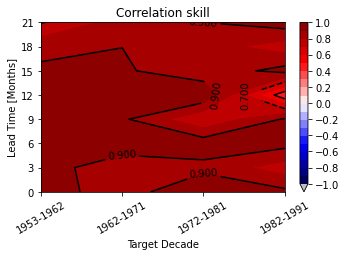

In [19]:
from os.path import join
from ninolearn.private import plotdir
plot_seasonal_skill_ZC(lead_times, r,  vmin=-1, vmax=1)
# plt.contour(np.arange(1,5),lead_times, p, [0.9, 0.95, 0.99], linestyles=['solid', 'dashed', 'dotted'], colors='k')
plt.title('Correlation skill')
# plt.tight_layout()
plt.savefig(join(plotdir, 'TL_r_skill_' + train_version + '_' + test_version))

Now we also want to compare the skill of the reference case AI to that of the Distorted physics AI. This can be done by plotting the ACC skill of both DEM instances together as follows

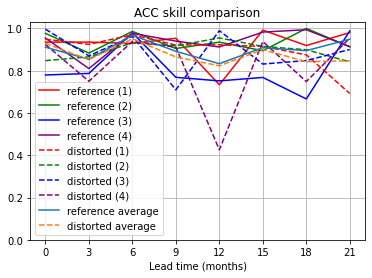

In [12]:
from ninolearn.plot.evaluation import ACC_skill_comparison_ZC

ACC_skill_comparison_ZC(r, rref, lead_times, train_version, test_version, plot_individual = True, plot_avg = True)


## Make predictions for the test data set
Now we can use the trained models to make predicitons on the test data set to evaluate how good the model perfoms on a data set that it never saw before.

In [21]:
pred_mean, pred_std = model.predict(testX)

NameError: name 'model' is not defined

In [ ]:
# from ninolearn.learn.fit import cross_hindcast_dem, cross_hindcast
# cross_hindcast(model, pipeline, 'DEM')
# # cross_hindcast_dem(model, pipeline, 'DEM')

## Plot the prediction
Let's see how the predicion is looking like

In [ ]:
import matplotlib.pyplot as plt
from ninolearn.plot.prediction import plot_prediction
import pandas as pd
from ninolearn.pathes import plotdir

from os.path import join


plt.subplots(figsize=(15,3.5))
plt.axhspan(-0.5,
            -6,
            facecolor='blue',
            alpha=0.1,zorder=0)

plt.axhspan(0.5,
            6,
            facecolor='red',
            alpha=0.1,zorder=0)

plt.xlim(testtimey[0], testtimey[-1])
plt.ylim(-3,3)

# plot the prediction
plot_prediction(testtimey, pred_mean, std=pred_std, facecolor='royalblue', line_color='navy')

# plot the observation
plt.plot(timey, y, "r", label = 'observation')
plt.legend()

plt.savefig(join(plotdir, f'predicVSobs_{version}_{lead_time}lead'))

plt.show()

## Evaluate the model

We can evaluate the model a bit more quantitatively using the loss function that was used to train the model, namely the negative-log-likelihood of the Gaussian and the correlation between the predicted mean and the observed ONI index.

In [ ]:
# from ninolearn.plot.evaluation import plot_correlation, plot_confMat, plot_seasonal_skill

# loss = model.evaluate(testy, pred_mean, pred_std)
# print(f"Loss (Negative-Log-Likelihood): {loss}")

# # make a plot of the seasonal correaltion
# # note: - pd.tseries.offsets.MonthBegin(1) appears to ensure that the correlations are plotted
# # agains the correct season
# plot_correlation(testy, pred_mean, testtimey - pd.tseries.offsets.MonthBegin(1), title="")

# # plot_seasonal_skill(leadtime, r_seas)

# # plt.savefig(join(plotdir, f'correlation_{version}_{lead_time}lead'))






In [ ]:
plot_seasonal_skill_ZC(lead_times, r,  vmin=0, vmax=1)
plt.contour(np.arange(1,5),lead_times, p, linestyles=['solid', 'dashed', 'dotted'], colors='k')
plt.title('Correlation skill')
plt.tight_layout()